In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

In [22]:
# Matplotlib color options.
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#90c3e2', '#de6e63', '#f1cb82']) # BRY.

In [23]:
def get_src(mother_folder='dissertation-york'):
    s = os.getcwd()
    s_list = s.split('/')
    for i, dir in enumerate(s_list):
        if dir == mother_folder:
            return '/'.join(s_list[:i+1])
    raise LookupError('No src folders found')


In [24]:
src = get_src()
print(src)

/Users/jakecordery/Desktop/dissertation-york


In [25]:
dfLSTM = pd.read_csv(os.path.join(src, 'results/lstm_results.csv'))
dfbiLSTM = dfLSTM[dfLSTM['bidirectional'] == 1]
dfLSTM = dfLSTM[dfLSTM['bidirectional'] == 0]

In [26]:
from matplotlib.legend_handler import HandlerPatch
class HandlerHatchedPatch(HandlerPatch):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        # Use the full facecolor tuple rather than just the first element.
        patch = mpatches.Rectangle([xdescent, ydescent], width, height,
                                   facecolor=orig_handle.get_facecolor(),
                                   edgecolor=orig_handle.get_edgecolor(),
                                   hatch=orig_handle.get_hatch())
        patch.set_transform(trans)
        return [patch]

class HatchedPatch(mpatches.Patch):
    pass

Number of neurons vs validation loss, for each input size.


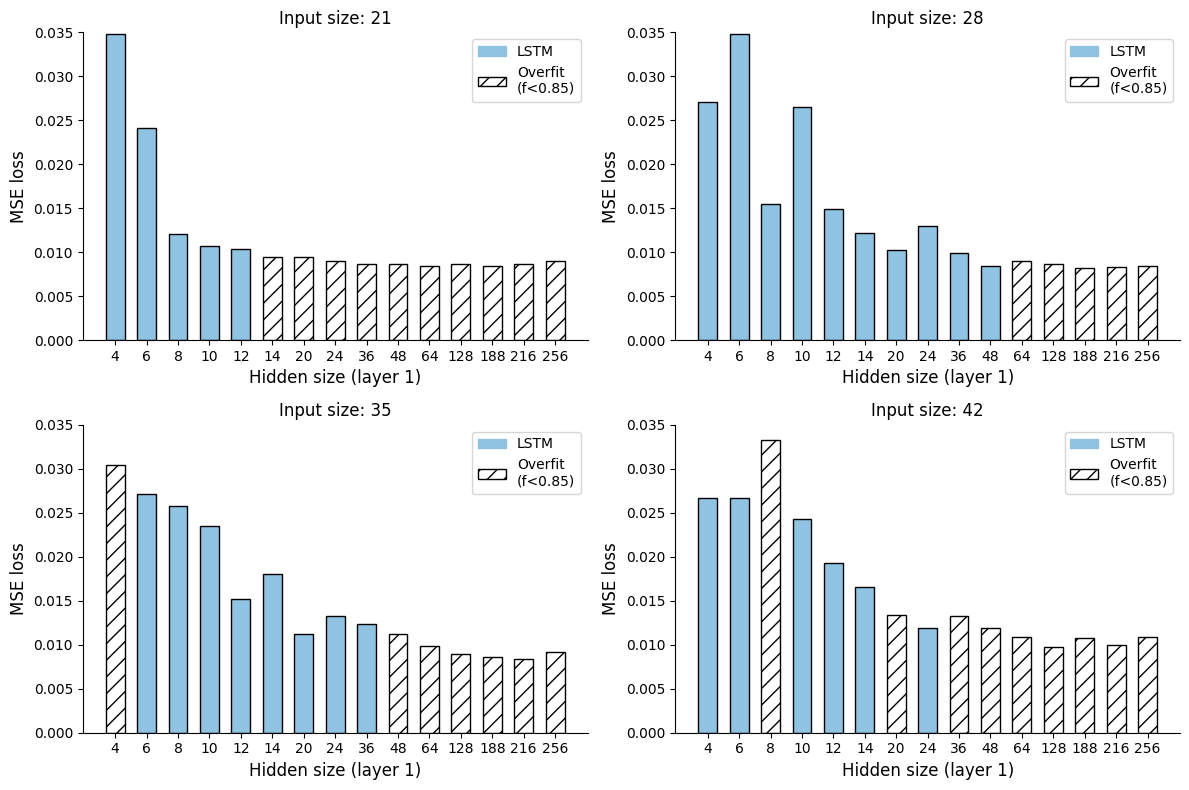

In [27]:
# LSTM 28 day window number of neurons.
window_sizes = [28, 35, 42, 49]
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

subplot_positions = {
    28: (0, 0),
    42: (0, 1),   # swapped: window 42 now goes to row 1, col 0
    35: (1, 0),   # swapped: window 35 now goes to row 0, col 1
    49: (1, 1)
}

for i, window_size in enumerate(window_sizes):
    j, k = subplot_positions[window_size]

    filtered_lstm = dfLSTM[(dfLSTM['window_size'] == window_size)]
    x_labels = filtered_lstm.hidden_size1.astype(str).tolist()
    x_positions = range(len(x_labels))

    for pos, (_, row) in enumerate(filtered_lstm.iterrows()):
        if row['fit_ratio'] >= 0.85:
            bar_color = '#90c3e2'
            hatch = None
        else:
            bar_color = 'white'
            hatch = '//'
        ax[k, j].bar(x_positions[pos], row['validation_loss'], 
                     color=bar_color, edgecolor='black', hatch=hatch, width=0.6)

    ax[k, j].set_xticks(list(x_positions))
    ax[k, j].set_xticklabels(x_labels, fontsize=10)
    ax[k, j].set_xlabel('Hidden size (layer 1)', fontsize=12)
    ax[k, j].set_ylabel('MSE loss', fontsize=12)
    ax[k, j].set_title(f'Input size: {window_size-7}')

    ax[k, j].set_ylim(0, 0.035)

    ax[k, j].spines['top'].set_visible(False)
    ax[k, j].spines['right'].set_visible(False)

    l1 = mpatches.Patch(color='#90c3e2', label='LSTM')
    overfit = HatchedPatch(facecolor='#FFFFFF', hatch='//', label='Overfit\n(f<0.85)', edgecolor='k')
    #overfit = mpatches.Patch(color='#FFFFFF', hatch='//', label='Overfit\n(f<0.85)', edgecolor='k')
    ax[k, j].legend(handles=[l1, overfit],
            handler_map={HatchedPatch: HandlerHatchedPatch()})
    

plt.tight_layout()
plt.savefig(os.path.join(src, 'figures/LSTM_neurons_vs_loss.png'), dpi=500, bbox_inches='tight')
print("Number of neurons vs validation loss, for each input size.")
plt.show()

Number of neurons vs validation loss, for each input size.


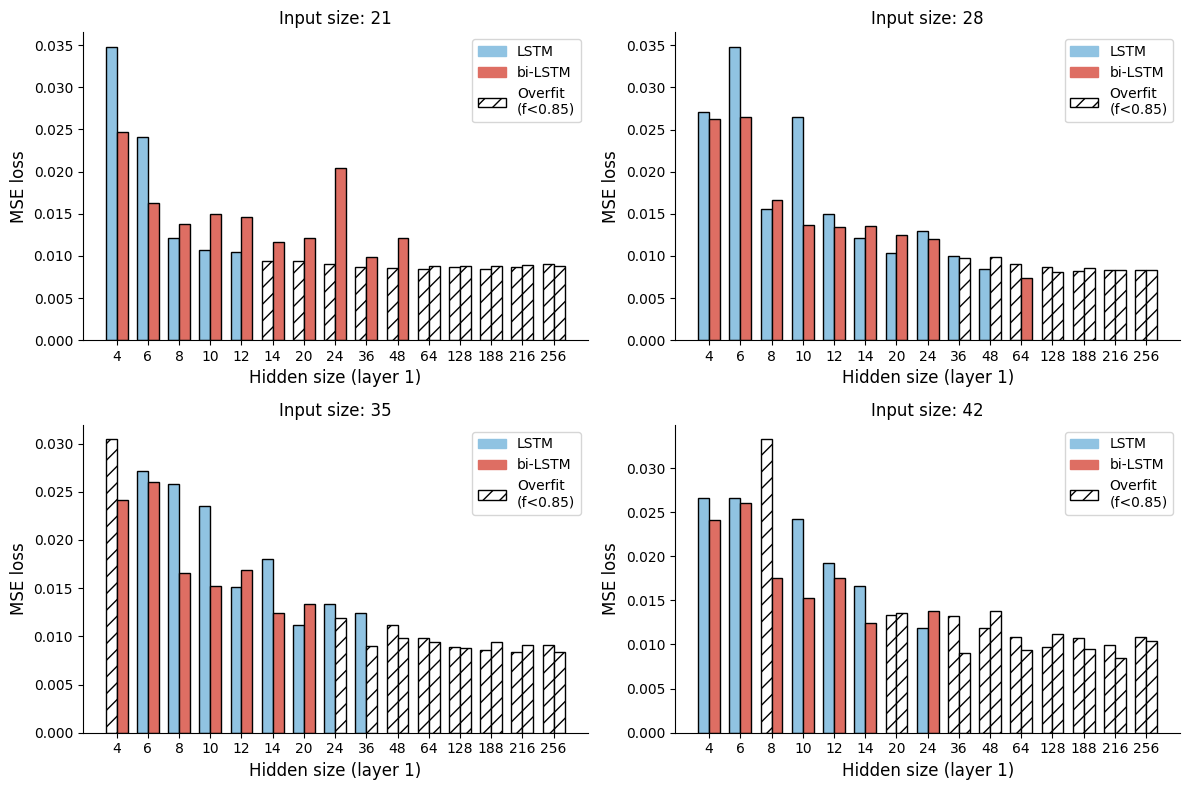

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Define the desired window sizes
window_sizes = [28, 35, 42, 49]

# Create a mapping of window_size to subplot positions (row, col)
subplot_positions = {
    28: (0, 0),
    42: (1, 0),   # swapped: window 42 now goes to row 1, col 0
    35: (0, 1),   # swapped: window 35 now goes to row 0, col 1
    49: (1, 1)
}

fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Loop over each window size using the mapping above.
for window_size in window_sizes:
    k, j = subplot_positions[window_size]
    # Filter your DataFrames for the current window size
    filtered_lstm = dfLSTM[dfLSTM['window_size'] == window_size]
    filtered_bilstm = dfbiLSTM[dfbiLSTM['window_size'] == window_size]
    
    # Convert the hidden_size1 to string for the x labels
    x_labels = filtered_lstm.hidden_size1.astype(str).tolist()
    n = len(x_labels)
    # Create an array for x positions for the different categories.
    x = np.arange(n)
    
    # Set a width for each bar (half-width for each group)
    width = 0.35

    # Plot for each row of the filtered DataFrames.
    for pos, ((_, row1), (_, row2)) in enumerate(zip(filtered_lstm.iterrows(), filtered_bilstm.iterrows())):
        # Determine color and hatch for LSTM bar based on its fit_ratio.
        if row1['fit_ratio'] >= 0.85:
            color1 = '#90c3e2'
            hatch1 = None
        else:
            color1 = 'white'
            hatch1 = '//'
        # Plot LSTM bar to the left of center.
        ax[k, j].bar(x[pos] - width/2, row1['validation_loss'], width,
                     color=color1, edgecolor='black', hatch=hatch1, label='LSTM' if pos == 0 else "")

        # Determine color and hatch for bi-LSTM bar.
        if row2['fit_ratio'] >= 0.85:
            color2 = '#de6e63'
            hatch2 = None
        else:
            color2 = 'white'
            hatch2 = '//'
        # Plot bi-LSTM bar to the right of center.
        ax[k, j].bar(x[pos] + width/2, row2['validation_loss'], width,
                     color=color2, edgecolor='black', hatch=hatch2, label='bi-LSTM' if pos == 0 else "")

    # Set xticks to be in the center of the grouped bars.
    ax[k, j].set_xticks(x)
    ax[k, j].set_xticklabels(x_labels, fontsize=10)
    ax[k, j].set_xlabel('Hidden size (layer 1)', fontsize=12)
    ax[k, j].set_ylabel('MSE loss', fontsize=12)
    ax[k, j].set_title(f'Input size: {window_size-7}')
    
    # Optionally, remove top and right spines.
    ax[k, j].spines['top'].set_visible(False)
    ax[k, j].spines['right'].set_visible(False)
    # Add legend (only once per subplot)
    ax[k, j].legend()
    l1 = mpatches.Patch(color='#90c3e2', label='LSTM')
    l2 = mpatches.Patch(color='#de6e63', label='bi-LSTM')
    overfit = HatchedPatch(facecolor='#FFFFFF', hatch='//', label='Overfit\n(f<0.85)', edgecolor='k')
    #overfit = mpatches.Patch(color='#FFFFFF', hatch='//', label='Overfit\n(f<0.85)', edgecolor='k')
    ax[k, j].legend(handles=[l1, l2, overfit],
            handler_map={HatchedPatch: HandlerHatchedPatch()})

plt.tight_layout()
# Save the figure (update src to your destination path)
plt.savefig(os.path.join(src, 'figures/LSTM_biLSTM_neurons_vs_loss.png'), dpi=500, bbox_inches='tight')
print("Number of neurons vs validation loss, for each input size.")
plt.show()

In [29]:
# Load GCN experimental data.
dfGCN = pd.read_csv(os.path.join(src, 'results/gcn_results.csv'))

Number of neurons vs validation loss, for each input size.


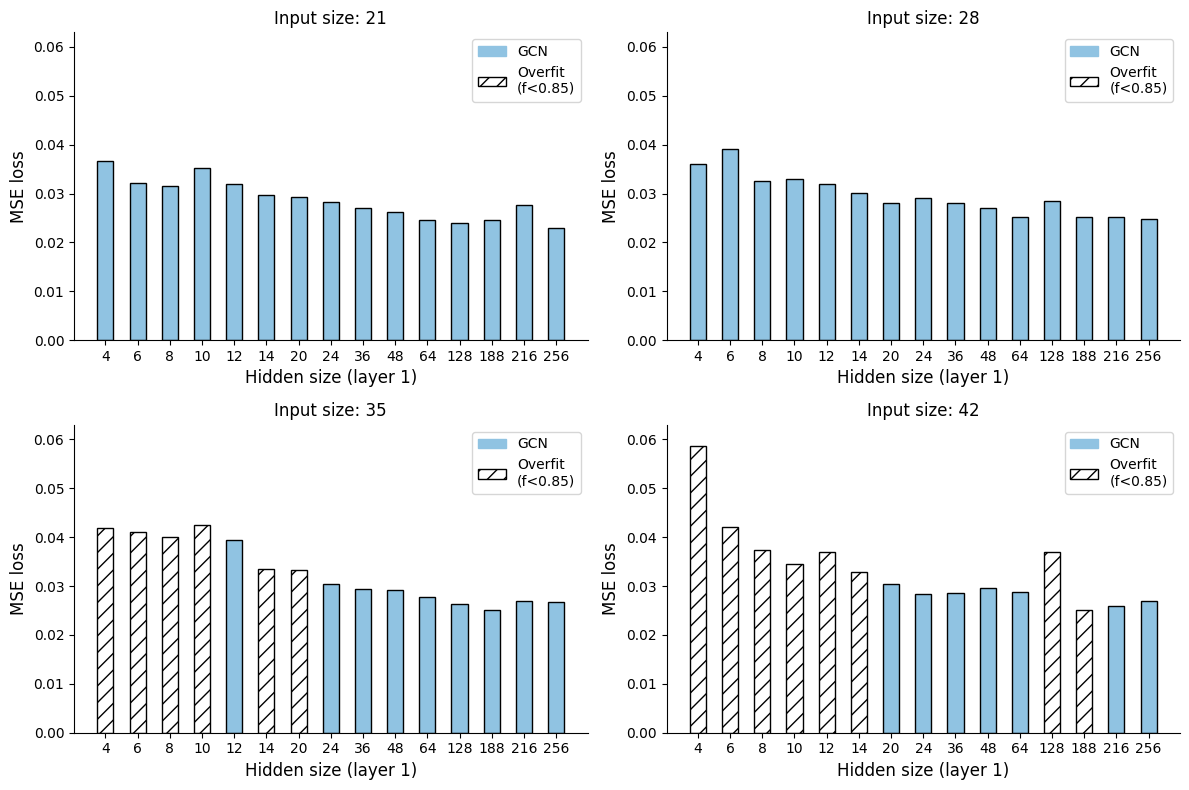

In [30]:
# Plot the trend of number of neurons vs validation loss for each input size.
window_sizes = dfGCN.window_size.unique()
window_sizes = [28, 35, 42, 49]
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
for i, window_size in enumerate(window_sizes):
    k, j = subplot_positions[window_size]

    filtered_gcn = dfGCN[(dfGCN['window_size'] == window_size) & (dfGCN['hidden_size2'] == 0)]
    # Convert the hidden_size1 to string for the x labels
    x_labels = filtered_gcn.hidden_size1.astype(str).tolist()
    n = len(x_labels)
    # Create an array for x positions for the different categories.
    x = np.arange(n)
    
    # Set a width for each bar (half-width for each group)
    width = 0.5

    # Plot for each row of the filtered DataFrames.
    for pos, (_, row) in enumerate(filtered_gcn.iterrows()):
        # Determine color and hatch for LSTM bar based on its fit_ratio.
        if row['fit_ratio'] >= 0.85:
            color1 = '#90c3e2'
            hatch1 = None
        else:
            color1 = 'white'
            hatch1 = '//'
        # Plot LSTM bar to the left of center.
        ax[k, j].bar(x[pos], row['validation_loss'], width,
                     color=color1, edgecolor='black', hatch=hatch1, label='GCN' if pos == 0 else "")

        
    # Set xticks to be in the center of the grouped bars.
    ax[k, j].set_xticks(x)
    ax[k, j].set_xticklabels(x_labels, fontsize=10)
    ax[k, j].set_xlabel('Hidden size (layer 1)', fontsize=12)
    ax[k, j].set_ylabel('MSE loss', fontsize=12)
    ax[k, j].set_title(f'Input size: {window_size-7}')

    ax[k, j].set_ylim(0, 0.063)
    
    # Optionally, remove top and right spines.
    ax[k, j].spines['top'].set_visible(False)
    ax[k, j].spines['right'].set_visible(False)
    # Add legend (only once per subplot)
    l1 = mpatches.Patch(color='#90c3e2', label='GCN')
    overfit = HatchedPatch(facecolor='#FFFFFF', hatch='//', label='Overfit\n(f<0.85)', edgecolor='k')
    #overfit = mpatches.Patch(color='#FFFFFF', hatch='//', label='Overfit\n(f<0.85)', edgecolor='k')
    ax[k, j].legend(handles=[l1, overfit],
            handler_map={HatchedPatch: HandlerHatchedPatch()})


plt.tight_layout()
plt.savefig(os.path.join(src, 'figures/GCN_neurons_vs_loss.png'), dpi=500, bbox_inches='tight')
print("Number of neurons vs validation loss, for each input size.")
plt.show()

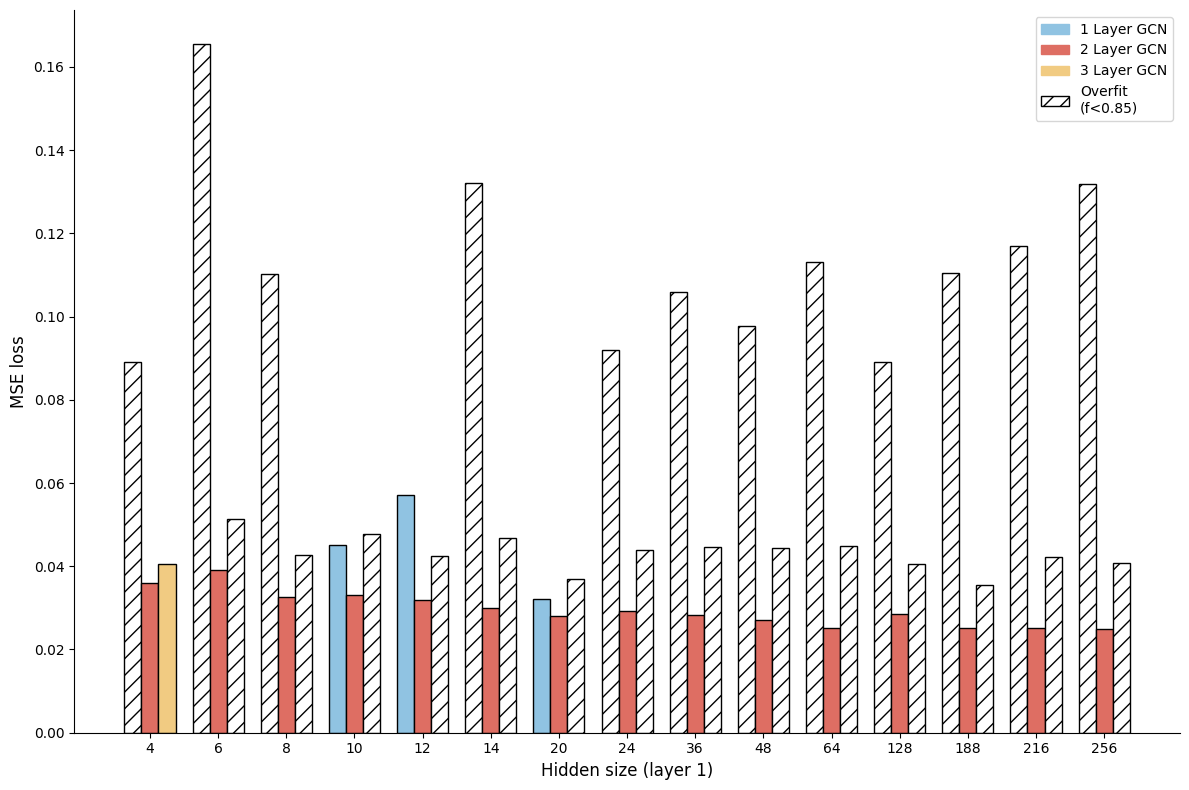

In [31]:
# Filter dataframe for one, two and three layer results
one_layer = dfGCN[(dfGCN['window_size'] == 350) & (dfGCN['hidden_size2'] == 0)]
two_layer = dfGCN[(dfGCN['window_size'] == 35) & (dfGCN['hidden_size2'] == 0)]
three_layer = dfGCN[(dfGCN['window_size'] == 35) & (dfGCN['hidden_size2'] != 0)]

# Convert hidden_size1 to string for consistent x-axis labels
labels = one_layer.hidden_size1.astype(str).values
x = np.arange(len(labels))  # Label locations.
width = 0.22  # Width of each bar.

plt.figure(figsize=(12, 8))
eta = 5e-2

x_labels = filtered_gcn.hidden_size1.astype(str).tolist()
n = len(x_labels)
# Create an array for x positions for the different categories.
x = np.arange(n)
    
# Set a width for each bar (half-width for each group)
width = 0.25

# Plot for each row of the filtered DataFrames.
for pos, (_, row) in enumerate(one_layer.iterrows()):
    # Determine color and hatch for LSTM bar based on its fit_ratio.
    if row['fit_ratio'] >= 0.85:
            color1 = '#90c3e2'
            hatch1 = None
    else:
        color1 = 'white'
        hatch1 = '//'
    # Plot LSTM bar to the left of center.
    plt.bar(x[pos] - width, row['validation_loss'], width,
                    color=color1, edgecolor='black', hatch=hatch1)
    
for pos, (_, row) in enumerate(two_layer.iterrows()):
    # Determine color and hatch for LSTM bar based on its fit_ratio.
    if row['fit_ratio'] >= 0.85:
            color1 = '#de6e63'
            hatch1 = None
    else:
        color1 = 'white'
        hatch1 = '//'
    # Plot LSTM bar to the left of center.
    plt.bar(x[pos], row['validation_loss'], width,
                    color=color1, edgecolor='black', hatch=hatch1)

for pos, (_, row) in enumerate(three_layer.iterrows()):
    # Determine color and hatch for LSTM bar based on its fit_ratio.
    if row['fit_ratio'] >= 0.85:
            color1 = '#f1cb82'
            hatch1 = None
            label1 = '3 Layer GCN'
    else:
        color1 = 'white'
        hatch1 = '//'
        label1 = 'Overfit'
    # Plot LSTM bar to the left of center.
    plt.bar(x[pos] + width, row['validation_loss'], width,
                    color=color1, edgecolor='black', hatch=hatch1)    

        
# Set xticks to be in the center of the grouped bars.
plt.xticks(x, labels=x_labels)
plt.xlabel('Hidden size (layer 1)', fontsize=12)
plt.ylabel('MSE loss', fontsize=12)
#plt.title(f'Input size: {window_size-7}')
    
# Optionally, remove top and right spines.
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

l1 = mpatches.Patch(color='#90c3e2', label='1 Layer GCN')
l2 = mpatches.Patch(color='#de6e63', label='2 Layer GCN')
l3 = mpatches.Patch(color='#f1cb82', label='3 Layer GCN')
overfit = HatchedPatch(facecolor='#FFFFFF', hatch='//', label='Overfit\n(f<0.85)', edgecolor='k')
#overfit = mpatches.Patch(color='#FFFFFF', hatch='//', label='Overfit\n(f<0.85)', edgecolor='k')
plt.legend(handles=[l1, l2, l3, overfit],
           handler_map={HatchedPatch: HandlerHatchedPatch()})

plt.tight_layout()
plt.savefig(os.path.join(src, 'figures/GCN_1_2_3_layer.png'), dpi=500, bbox_inches='tight')
plt.show()


In [32]:
# Best GCN models vs best LSTM models.

# Best LSTM input: hidden size. 21:36 bi:1, 28:20 bi:0, 35:14 bi:1, 42:20 bi:0.
# Best GCN input: hidden size. 21:128 28:256 35:128 42:216.

allowed = {(28, 36, 1), (35, 20, 0), (42, 14, 1), (49, 20, 0)}
dfLSTM = pd.read_csv(os.path.join(src, 'results/lstm_results.csv'))
best_lstm = dfLSTM[dfLSTM[['window_size', 'hidden_size1', 'bidirectional']].apply(lambda row: tuple(row) in allowed, axis=1)]
print(best_lstm.shape)

dfGCN = pd.read_csv(os.path.join(src, 'results/gcn_results.csv'))
allowed = {(28, 128), (35, 256), (42, 128), (49, 216)}
best_gcn = dfGCN[dfGCN[['window_size', 'hidden_size1']].apply(lambda row: tuple(row) in allowed, axis=1)]
best_gcn = best_gcn[best_gcn.hidden_size2 == 0]



(4, 9)


In [33]:
# Open the fitting to n months of dataframe.
fitLSTM_df = pd.read_csv('/Users/jakecordery/Desktop/dissertation-york/results/lstm_fraction_results.csv')
print(fitLSTM_df.columns)


Index(['window_size', 'hidden_size1', 'bidirectional', 'step', 'training_days',
       'training_loss', 'validation_loss', 'fit_ratio'],
      dtype='object')


Number of neurons vs validation loss, for each input size.


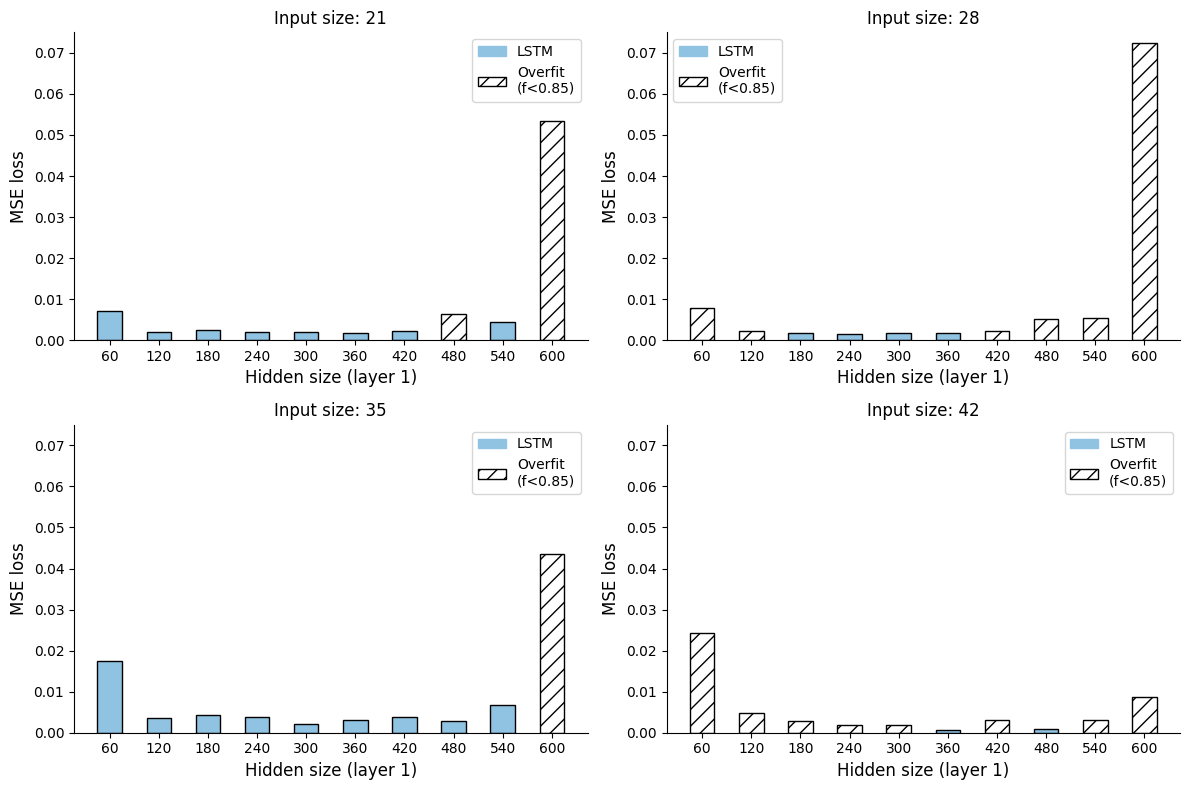

In [34]:
window_sizes = fitLSTM_df.window_size.unique()
window_sizes = [28, 35, 42, 49]
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
for i, window_size in enumerate(window_sizes):
    k, j = subplot_positions[window_size]

    filtered_lstm = fitLSTM_df[(fitLSTM_df['window_size'] == window_size)]
    # Convert the hidden_size1 to string for the x labels
    x_labels = filtered_lstm.training_days.astype(str).tolist()
    n = len(x_labels)
    # Create an array for x positions for the different categories.
    x = np.arange(n)
    
    # Set a width for each bar (half-width for each group)
    width = 0.5

    # Plot for each row of the filtered DataFrames.
    for pos, (_, row) in enumerate(filtered_lstm.iterrows()):
        # Determine color and hatch for LSTM bar based on its fit_ratio.
        if row['fit_ratio'] >= 0.85:
            color1 = '#90c3e2'
            hatch1 = None
        else:
            color1 = 'white'
            hatch1 = '//'
        # Plot LSTM bar to the left of center.
        ax[k, j].bar(x[pos], row['validation_loss'], width,
                     color=color1, edgecolor='black', hatch=hatch1, label='LSTM' if pos == 0 else "")

        
    # Set xticks to be in the center of the grouped bars.
    ax[k, j].set_xticks(x)
    ax[k, j].set_xticklabels(x_labels, fontsize=10)
    ax[k, j].set_xlabel('Hidden size (layer 1)', fontsize=12)
    ax[k, j].set_ylabel('MSE loss', fontsize=12)
    ax[k, j].set_title(f'Input size: {window_size-7}')
    
    # Optionally, remove top and right spines.
    ax[k, j].spines['top'].set_visible(False)
    ax[k, j].spines['right'].set_visible(False)

    # Lims should remain the same for easy comparision.
    ax[k, j].set_ylim(0, 0.075)

    # Add legend (only once per subplot)
    l1 = mpatches.Patch(color='#90c3e2', label='LSTM')
    overfit = HatchedPatch(facecolor='#FFFFFF', hatch='//', label='Overfit\n(f<0.85)', edgecolor='k')
    #overfit = mpatches.Patch(color='#FFFFFF', hatch='//', label='Overfit\n(f<0.85)', edgecolor='k')
    ax[k, j].legend(handles=[l1, overfit],
            handler_map={HatchedPatch: HandlerHatchedPatch()})


plt.tight_layout()
plt.savefig(os.path.join(src, 'figures/step_lstm.png'), dpi=500, bbox_inches='tight')
print("Number of neurons vs validation loss, for each input size.")
plt.show()

In [35]:
# Open the fitting to n months of dataframe.
fitGCN_df = pd.read_csv('/Users/jakecordery/Desktop/dissertation-york/results/gcn_fraction_results.csv')
print(fitGCN_df.columns)

Index(['window_size', 'hidden_size1', 'step', 'training_days', 'training_loss',
       'validation_loss', 'fit_ratio'],
      dtype='object')


Number of neurons vs validation loss, for each input size.


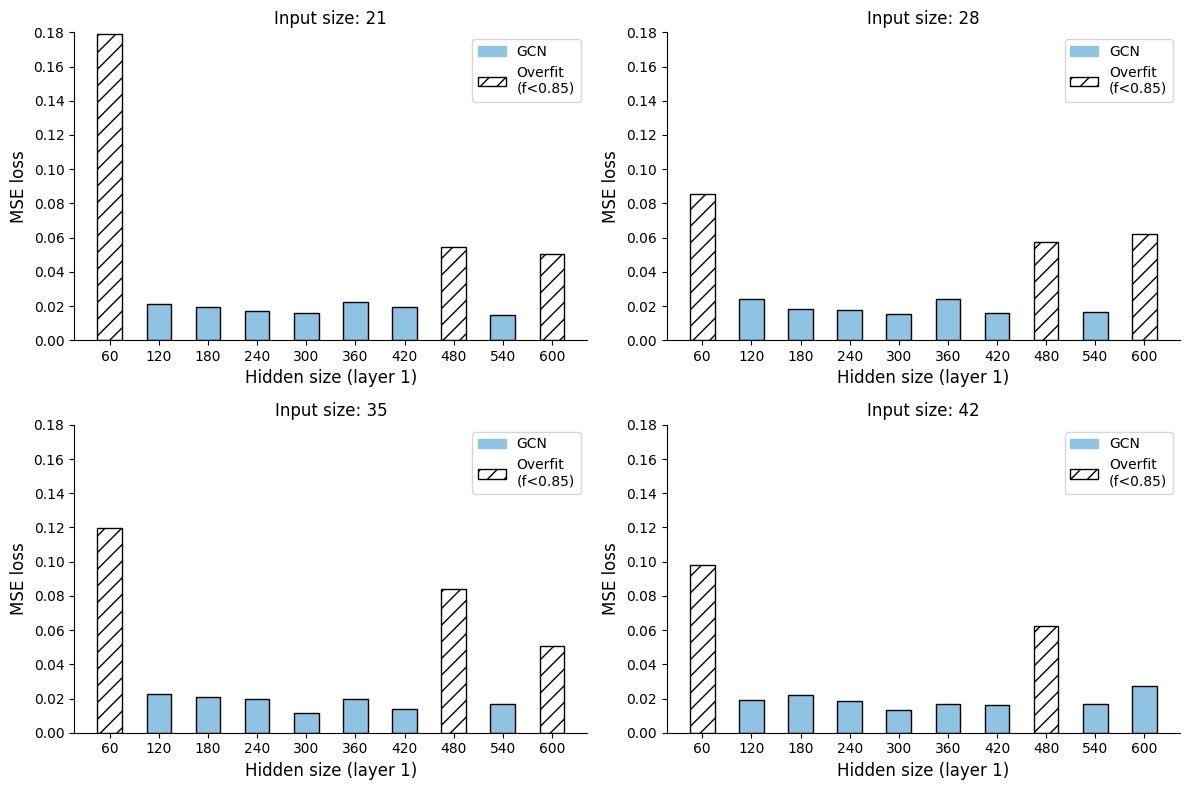

In [36]:
window_sizes = fitGCN_df.window_size.unique()
window_sizes = [28, 35, 42, 49]
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
for i, window_size in enumerate(window_sizes):
    k, j = subplot_positions[window_size]

    filtered_gcn = fitGCN_df[(fitGCN_df['window_size'] == window_size)]
    # Convert the hidden_size1 to string for the x labels
    x_labels = filtered_gcn.training_days.astype(str).tolist()
    n = len(x_labels)
    # Create an array for x positions for the different categories.
    x = np.arange(n)
    
    # Set a width for each bar (half-width for each group)
    width = 0.5

    # Plot for each row of the filtered DataFrames.
    for pos, (_, row) in enumerate(filtered_gcn.iterrows()):
        # Determine color and hatch for GCN bar based on its fit_ratio.
        if row['fit_ratio'] >= 0.85:
            color1 = '#90c3e2'
            hatch1 = None
        else:
            color1 = 'white'
            hatch1 = '//'
        # Plot LSTM bar to the left of center.
        ax[k, j].bar(x[pos], row['validation_loss'], width,
                     color=color1, edgecolor='black', hatch=hatch1, label='GCN' if pos == 0 else "")

        
    # Set xticks to be in the center of the grouped bars.
    ax[k, j].set_xticks(x)
    ax[k, j].set_xticklabels(x_labels, fontsize=10)
    ax[k, j].set_xlabel('Hidden size (layer 1)', fontsize=12)
    ax[k, j].set_ylabel('MSE loss', fontsize=12)
    ax[k, j].set_title(f'Input size: {window_size-7}')
    
    # Optionally, remove top and right spines.
    ax[k, j].spines['top'].set_visible(False)
    ax[k, j].spines['right'].set_visible(False)

    ax[k, j].set_ylim(0, 0.18)


    # Add legend (only once per subplot)
    l1 = mpatches.Patch(color='#90c3e2', label='GCN')
    overfit = HatchedPatch(facecolor='#FFFFFF', hatch='//', label='Overfit\n(f<0.85)', edgecolor='k')
    #overfit = mpatches.Patch(color='#FFFFFF', hatch='//', label='Overfit\n(f<0.85)', edgecolor='k')
    ax[k, j].legend(handles=[l1, overfit],
            handler_map={HatchedPatch: HandlerHatchedPatch()})


plt.tight_layout()
plt.savefig(os.path.join(src, 'figures/step_gcn.png'), dpi=500, bbox_inches='tight')
print("Number of neurons vs validation loss, for each input size.")
plt.show()